In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
from PIL import Image

device = torch.device('cuda')

In [2]:
class CIFAR100CustomDataset(Dataset):
    def __init__(self, root, train=True, transform=None):
        # Load the CIFAR-100 dataset
        self.data = datasets.CIFAR100(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

    def __getitem__(self, idx):
        # Get an image and its label
        img, label = self.data[idx]

        # Apply the transformations if provided
        if self.transform:
            img = self.transform(img)

        return img, label

In [3]:
transform = transforms.Compose([
    # transforms.Resize((64, 64)),  # Resize to 64x64 for VQ-VAE input
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

In [4]:
train_dataset = CIFAR100CustomDataset(root='./data', train=True, transform=transform)
test_dataset = CIFAR100CustomDataset(root='./data', train=False, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

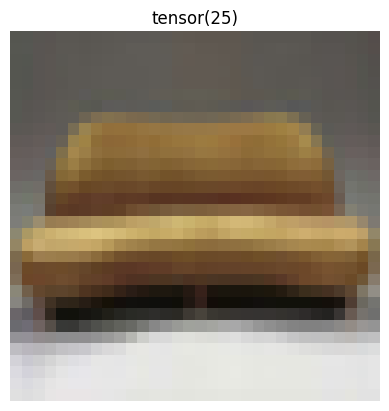

In [7]:
def show_single_image(image, label):
    plt.imshow(image.permute(1, 2, 0) * 0.5 + 0.5)  # Unnormalize and permute to HWC
    plt.title(label)
    plt.axis('off')
    plt.show()

show_single_image(images[10], labels[10])